### Explaining Fraud Detection Models

### Problem Definition

The original data is from an USA Insurance company and is published by Oracle. The dataset is about Vehicle Insurance Fraud which is submitting false or inflated claims for property damage or personal injuries after an car accident. Some common tactics include staging accidents where the perpetrators intentionally cause accidents to happen; using phantom passengers, where individuals who were not present at the scene of the accident claim to have sustained serious injuries; and making false personal injury claims where the injuries are greatly exaggerated. 

The task is to classify claims as either fraudulent or legitimate in order to save resources by not having to assign specialists to scrutinize every claim.

For simplicity, we massaged the data a bit. The fraud class and normal class are balanced and a subset of columns are selected. The processed dataset is provided as **FraudClaim_subset.csv**

Columns are described as below: 

1. VehicleCategory:  Vehicle types 
2. PastNumberOfClaims: Number of past claims of the insurance owner
3. VehiclePrice: Price of the car
4. AgeOfVehicle: Age of the car
5. AgeOfPolicyHolder: Age of the policy holder
6. NumberOfCars: Number of cars involved in the accident
7. FraudFound_P: target variable. 1 means fraudulent applications and 0 means normal ones.




In this work, our goal is to interpret decision tree and random forest models for fraud detection. The steps of this work are:

1. Read and prepare the data 
2. Fit 3 different ML models 
3. Calculate the default variable importance measure for the tree-based models
4. Check permutation importance scores
5. Use Lime to better understand how features contribute to the specific prediction

In [1]:
!pip


Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                  A helper command used for command completion.
  debug                   

In [2]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=521cb447275733bebbfed611c728e5aa780f7131f697078bac714eecd1c90516
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.inspection import permutation_importance

from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

In [4]:
df = pd.read_csv("FraudClaim_subset.csv")
df.head()

,VehicleCategory,PastNumberOfClaims,VehiclePrice,AgeOfVehicle,AgeOfPolicyHolder,NumberOfCars,FraudFound_P
0,Sport,2 to 4,20000 to 29000,7 years,31 to 35,2 vehicles,0
1,Sport,more than 4,30000 to 39000,more than 7,51 to 65,1 vehicle,0
2,Sedan,more than 4,more than 69000,more than 7,41 to 50,1 vehicle,0
3,Sedan,none,more than 69000,new,16 to 17,1 vehicle,0
4,Sport,2 to 4,20000 to 29000,more than 7,51 to 65,1 vehicle,0


### Task 1: DATA PROCESSING



Check the unique value of all columns

In [5]:
# your code
for col in df.columns:
    print(f"Unique values in column '{col}': {df[col].unique()}")

Unique values in column 'VehicleCategory': ['Sport' 'Sedan' 'Utility']
Unique values in column 'PastNumberOfClaims': ['2 to 4' 'more than 4' 'none' '1']
Unique values in column 'VehiclePrice': ['20000 to 29000' '30000 to 39000' 'more than 69000' '40000 to 59000'
 'less than 20000' '60000 to 69000']
Unique values in column 'AgeOfVehicle': ['7 years' 'more than 7' 'new' '6 years' '4 years' '5 years' '2 years'
 '3 years']
Unique values in column 'AgeOfPolicyHolder': ['31 to 35' '51 to 65' '41 to 50' '16 to 17' '36 to 40' 'over 65'
 '21 to 25' '26 to 30']
Unique values in column 'NumberOfCars': ['2 vehicles' '1 vehicle' '5 to 8' '3 to 4']
Unique values in column 'FraudFound_P': [0 1]


In [6]:
label_col = ['FraudFound_P']
fea_cols  = ['VehicleCategory', 'VehiclePrice', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfCars']

In [7]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.80)
X_df = df[fea_cols]
y_df = df[label_col]
X_train = X_df.iloc[itrain,:]
X_test  = X_df.iloc[itest, :]
y_train = y_df.iloc[itrain].values.ravel()
y_test  = y_df.iloc[itest].values.ravel()

In [8]:
vprice_categories = ['less than 20000', '20000 to 29000', '30000 to 39000', 
                     '40000 to 59000', '60000 to 69000', 'more than 69000'] 
pncalims_categories = ['none', '1', '2 to 4', 'more than 4']

ageofvehicle_categories = ['new', '2 years', '3 years', 
                           '4 years', '5 years', '6 years', 
                           '7 years', 'more than 7'] 
ageofpolicyholder_categories = ['16 to 17', '18 to 20', '21 to 25', 
                                 '26 to 30', '31 to 35', '36 to 40', 
                                '41 to 50', '51 to 65', 'over 65'] 
numberofcars_categories = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8'] 

In [9]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(sparse_output = False) # get feature names out therefore it is set to be dense
feature_transform = make_column_transformer(
    (ohe, ['VehicleCategory']), 
    (OrdinalEncoder(categories = [vprice_categories]), ['VehiclePrice']),
    (OrdinalEncoder(categories = [pncalims_categories]), ['PastNumberOfClaims']),
    (OrdinalEncoder(categories = [ageofvehicle_categories]), ['AgeOfVehicle']),
    (OrdinalEncoder(categories = [ageofpolicyholder_categories]), ['AgeOfPolicyHolder']),
    (OrdinalEncoder(categories = [numberofcars_categories]), ['NumberOfCars']),
    )


cat_cols = ['typeIsSedan', 'typeIsSport', 'typeIsUtility']  + ['VehiclePrice', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfCars']

In [10]:
X_train_fea = feature_transform.fit_transform(X_train)
X_test_fea  = feature_transform.transform(X_test)
X_train_fea = pd.DataFrame(X_train_fea, columns =cat_cols)
X_test_fea = pd.DataFrame(X_test_fea, columns =cat_cols)

In [11]:
X_train_fea.head()

,typeIsSedan,typeIsSport,typeIsUtility,VehiclePrice,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,NumberOfCars
0,1.0,0.0,0.0,1.0,1.0,6.0,5.0,0.0
1,1.0,0.0,0.0,1.0,0.0,5.0,5.0,0.0
2,0.0,1.0,0.0,1.0,1.0,6.0,5.0,0.0
3,0.0,0.0,1.0,5.0,2.0,7.0,7.0,0.0
4,1.0,0.0,0.0,1.0,0.0,6.0,4.0,1.0


*Findings:*

Both OneHotEncoder and OrdinalEncoder were used to handle categorical features. OneHotEncoder was used for "VehicleCategory" since it has more than two distinct values, while "PastNumberOfClaims" was encoded using an ordinal algorithm because it has ordered categories. Depending on the makeup of the categories, it makes sense to handle categorical features differently.

The ordinal encoding handled the missing values in the "PastNumberOfClaims" column as a different category. If missing values are thought to include some information, it makes appropriate to classify them as a separate category, although this choice should be based on domain expertise.

### Task 2: Fitting Three ML Models

In [12]:
# fit a shallow decision tree classifier
dt2 = tree.DecisionTreeClassifier(max_depth = 2)
dt2.fit(X_train_fea.values,y_train);

# fit a deep decision tree classifier
dt40 = tree.DecisionTreeClassifier(max_depth = 40)
dt40.fit(X_train_fea.values,y_train);

# fit random forest with predefined hyparameters
randomforest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=6)
randomforest.fit(X_train_fea.values,y_train);


Evaluate these three models using AUC metrics on training and testing

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
# your code
# Evaluate shallow decision tree on training and testing data
y_pred_train = dt2.predict_proba(X_train_fea.values)[:,1]
y_pred_test = dt2.predict_proba(X_test_fea.values)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)
print("Shallow decision tree AUC train: {:.3f}".format(auc_train))
print("Shallow decision tree AUC test: {:.3f}".format(auc_test))

Shallow decision tree AUC train: 0.642
Shallow decision tree AUC test: 0.619


In [15]:
# Evaluate deep decision tree on training and testing data
y_pred_train = dt40.predict_proba(X_train_fea.values)[:,1]
y_pred_test = dt40.predict_proba(X_test_fea.values)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)
print("Deep decision tree AUC train: {:.3f}".format(auc_train))
print("Deep decision tree AUC test: {:.3f}".format(auc_test))

Deep decision tree AUC train: 0.882
Deep decision tree AUC test: 0.574


In [16]:
# Evaluate random forest on training and testing data
y_pred_train = randomforest.predict_proba(X_train_fea.values)[:,1]
y_pred_test = randomforest.predict_proba(X_test_fea.values)[:,1]
auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)
print("Random forest AUC train: {:.3f}".format(auc_train))
print("Random forest AUC test: {:.3f}".format(auc_test))

Random forest AUC train: 0.785
Random forest AUC test: 0.644


*Findings:*

The random forest model performs the best on both training and testing data, as it has the highest AUC score on both sets. The shallow decision tree model appears to be slightly overfitting the data as the AUC score on the training set is higher than the AUC score on the testing set, but the difference is not very significant. The deep decision tree model appears to be significantly overfitting the data as the AUC score on the training set is much higher than the AUC score on the testing set, indicating that the model is not generalizing well to new data.

### Task 3: Built-in Feature Importance

Text(0.5, 1.0, 'Relative Feature Importance for dt2')

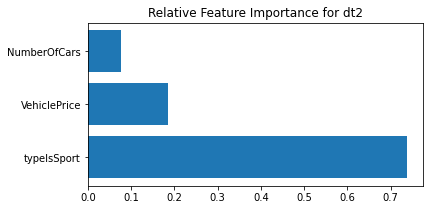

In [17]:
#Built-in Variable Importance
plt.figure(figsize=(6,3))
num=3


dt2_importances = dt2.feature_importances_
order = np.flip(np.argsort(dt2_importances))[0:num]
plt.barh(range(num),
         dt2_importances[order], 
         tick_label=X_train_fea.columns[order])
plt.title("Relative Feature Importance for dt2")


Check top3 important features for dt40 and randomforest models

Text(0.5, 1.0, 'Relative Feature Importance for dt40')

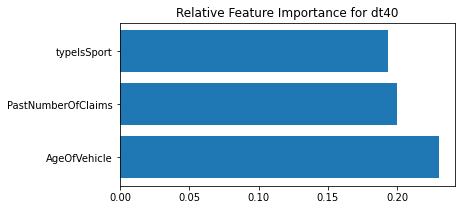

In [18]:
# your code
plt.figure(figsize=(6,3))
num=3

# Plot feature importance for dt40
dt40_importances = dt40.feature_importances_
order = np.flip(np.argsort(dt40_importances))[0:num]
plt.barh(range(num),
         dt40_importances[order], 
         tick_label=X_train_fea.columns[order])
plt.title("Relative Feature Importance for dt40")

Text(0.5, 1.0, 'Relative Feature Importance for Random Forest')

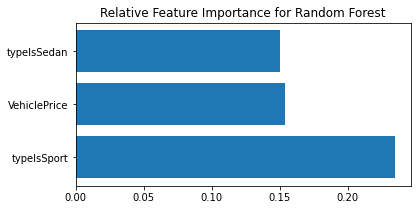

In [19]:
plt.figure(figsize=(6,3))
num=3

# Plot feature importance for random forest
rf_importances = randomforest.feature_importances_
order = np.flip(np.argsort(rf_importances))[0:num]
plt.barh(range(num),
         rf_importances[order], 
         tick_label=X_train_fea.columns[order])
plt.title("Relative Feature Importance for Random Forest")

*Findings:*

In general, the sport category is the most significant factor because it is represented in all three models and has a weight of more than 70% in the flat decision tree classifier. It currently has a connection of at least 20% with the decisions regarding fraud claim in three models.

## Task 4: Check Importance values using sklearn Permutation

In [20]:
r = permutation_importance(randomforest, X_test_fea, y_test,
                           n_repeats=30,
                           random_state=0)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without featu

Rank all of features based on importances mean value from high to low 

In [21]:
# your code
importances = r.importances_mean
sorted_idx = importances.argsort()[::-1]
for i in sorted_idx:
    print("{:<30} {:.3f}".format(X_test_fea.columns[i], importances[i]))

VehiclePrice                   0.058
typeIsSport                    0.054
typeIsSedan                    0.038
PastNumberOfClaims             0.024
AgeOfPolicyHolder              0.022
AgeOfVehicle                   0.016
typeIsUtility                  0.000
NumberOfCars                   -0.001


*Findings:*

Built-in feature importance is determined during the development of the random forest model, whereas permutation importance requires numerous model the re-fittings. Permutation importance is also easier to explain than feature importance, which depends on the stressful random forest methodology, because it is closely linked to prediction accuracy.

## Task 5: Using Lime

In [22]:
explainer = LimeTabularExplainer(X_train_fea.values,
                                 feature_names=X_train_fea.columns,
                                 class_names = ['normal', 'fraud'],
                                 mode='classification')

In [23]:
idx = 35

exp = explainer.explain_instance(X_train_fea.values[idx], 
                                 randomforest.predict_proba, 
                                 num_features = X_train_fea.iloc[idx,:].size)

print('Observation #: %d' % idx)
print('Probability(Fraud) =', randomforest.predict_proba(X_train_fea.values)[idx][1])
print('True class: %s' % y_train[idx])

Observation #: 35
Probability(Fraud) = 0.18068390703598197
True class: 0


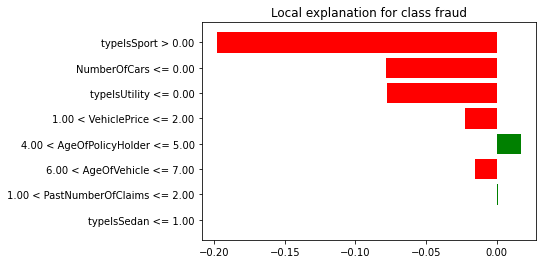

In [24]:
### Plot the results
exp.as_pyplot_figure();

Change the index number and see what is the generated explanation

In [31]:
# your code
idx2 = 80

exp2 = explainer.explain_instance(X_train_fea.values[idx2], 
                                 randomforest.predict_proba, 
                                 num_features = X_train_fea.iloc[idx2,:].size)

print('Observation #: %d' % idx2)
print('Probability(Fraud) =', randomforest.predict_proba(X_train_fea.values)[idx2][1])
print('True class: %s' % y_train[idx2])

Observation #: 80
Probability(Fraud) = 0.28693309120534083
True class: 1


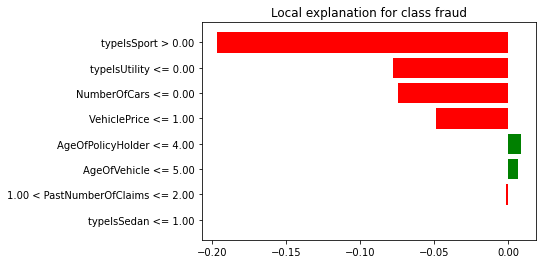

In [33]:
### Plot the results
exp2.as_pyplot_figure();

*Findings:*

The 80th sample is chosen for the first LIME, and 8 contributing characteristics are chosen from them. The chance of fraud in this sample is 0.286, indicating fraud is present in the data. Also, the graph demonstrates in fine detail how each weighted variable affected the result. Overall, it is consistent with the other interpretation of the random forest because the sport plays the most part in describing the model, both in the two LIME samples and in terms of the significance of the characteristics and the permutation. Yet LIME reads the trait as negatively associated, but the permutation believes it would contribute positively.